# **Stable Diffusion** 🎨
*...using `🧨diffusers`*

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

Let's get started!

## 1. How to use `StableDiffusionPipeline`

Before diving into the theoretical aspects of how Stable Diffusion functions,
let's try it out a bit 🤗.

In this section, we show how you can run text to image inference in just a few lines of code!

### Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

In [1]:
!nvidia-smi

Tue Apr  2 14:45:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 598.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 784.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model. In this notebook we use Stable Diffusion version 1.4 ([CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)), but there are other variants that you may want to try:
* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1). This version can produce images with a resolution of 768x768, while the others work at 512x512.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

We want to ensure that every free Google Colab can run Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`.

If you want to ensure the highest possible precision, please make sure to remove `torch_dtype=torch.float16` at the cost of a higher memory usage.

In [3]:
import torch
from diffusers import StableDiffusionPipeline
import os

cache_dir = "./cache_dir/models"
os.makedirs(cache_dir, exist_ok=True)

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float32, cache_dir=cache_dir)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Next, let's move the pipeline to GPU to have faster inference.

In [4]:
pipe = pipe.to("cuda")
pipe.save_pretrained("./cache_dir/models/sd_1.5", safe_serialization=False)

And we are ready to generate images:

  0%|          | 0/30 [00:00<?, ?it/s]

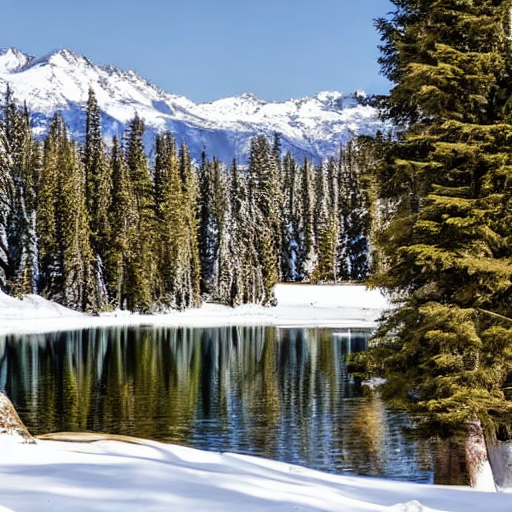

In [5]:
import torch

generator = torch.Generator("cuda").manual_seed(42)

prompt = "a view of a lake with snow covered mountains and trees"
negative = "fog"

image = pipe(prompt=prompt, negative_prompt=negative, num_inference_steps=30, guidance_scale=7.5, generator=generator).images[0]

# Now to display an image you can either save it such as:
image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with
image


### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

  0%|          | 0/50 [00:00<?, ?it/s]

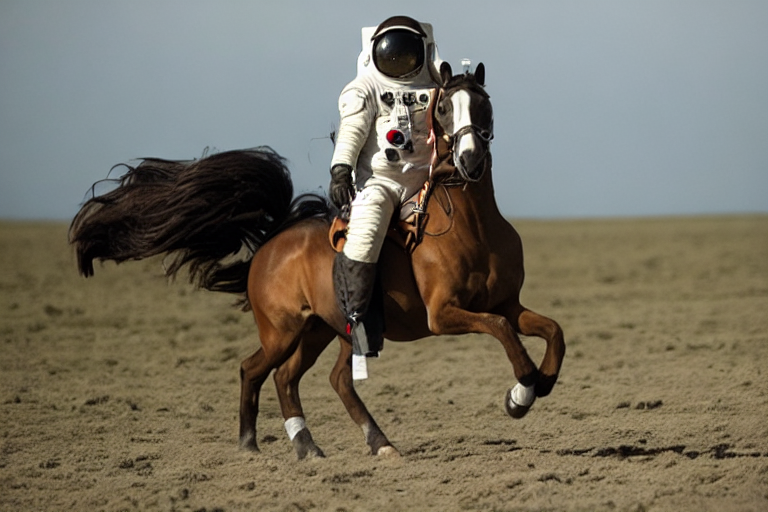

In [ ]:
prompt = "a photograph of an astronaut riding a horse"
image = pipe(prompt, height=512, width=768).images[0]
image

## 2. What is Stable Diffusion

Now, let's go into the theoretical part of Stable Diffusion 👩‍🎓.

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default).
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Heun Discrete scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [DPM Solver Multistep scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). This scheduler is able to achieve great quality in less steps. You can try with 25 instead of the default 50!

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components.

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [6]:
del pipe

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from diffusers import DPMSolverMultistepScheduler
from diffusers import EulerAncestralDiscreteScheduler
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
dtype=torch.float16
model_id = "/content/cache_dir/models/sd_1.5"

scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(model_id,  subfolder="tokenizer", torch_dtype=dtype)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=dtype)


Now instead of loading the pre-defined scheduler, we'll use the K-LMS scheduler instead.

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler, KDPM2DiscreteScheduler

scheduler = KDPM2DiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")

Next we move the models to the GPU.

In [ ]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 25            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
seed = 42                           # Seed for generator  to create the inital latent noise
batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
print((text_embeddings.dtype))

torch.float16


We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
print(max_length)
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
print(uncond_embeddings.dtype)


77
torch.float16


For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
print(text_embeddings.dtype)

torch.float16


Generate the intial random noise.

In [ ]:
generator = torch.Generator("cpu").manual_seed(seed)
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator, dtype=dtype)
latents = latents.to(device)
print(latents.dtype)

torch.float16


In [ ]:
latents.shape

torch.Size([1, 4, 64, 64])

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/49 [00:00<?, ?it/s]

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
from PIL import Image

def decode_img_latents(latents):
  latents = latents.clone()
  latents = 1 / 0.18215 * latents

  with torch.no_grad():
    image = vae.decode(latents).sample

  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images[0]


In [ ]:
img = decode_img_latents(latents.to(dtype))

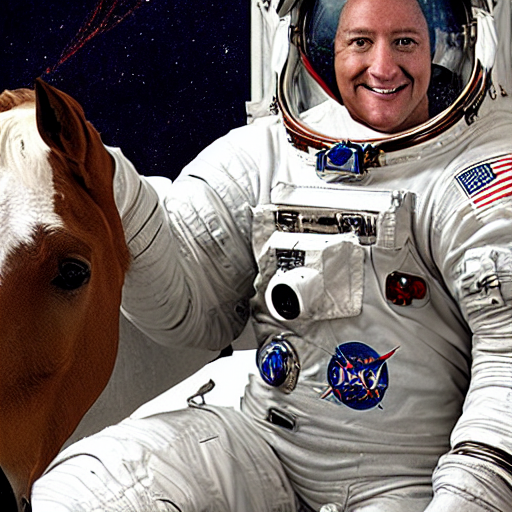

In [ ]:
img

## Create video

In [ ]:
# video from latent

from tqdm.auto import tqdm
from torch import autocast


scheduler.set_timesteps(num_inference_steps)

generator = torch.Generator("cpu").manual_seed(seed)
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,dtype=dtype)

latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma

all_latents = [latents]
for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample
  all_latents.append(latents)

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
images = []
for latent in all_latents:
  img = decode_img_latents(latent)
  images.append(img)

In [ ]:
import cv2
import os
import numpy as np
from IPython.display import HTML
from base64 import b64encode

def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [ ]:
imgs_to_video(images, "video.mp4")
display_video("video.mp4")

## Use diffusers pipeline

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from diffusers import EulerAncestralDiscreteScheduler, KDPM2DiscreteScheduler, DPMSolverMultistepScheduler
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
dtype=torch.float16
model_id = "/content/cache_dir/models/civitai_model"

scheduler = KDPM2DiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
tokenizer = CLIPTokenizer.from_pretrained(model_id,  subfolder="tokenizer", torch_dtype=dtype)
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae", torch_dtype=dtype)
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder", torch_dtype=dtype)


pipeline = StableDiffusionPipeline(tokenizer=tokenizer,
                                    vae=vae, unet=unet,
                                    text_encoder=text_encoder,
                                    scheduler=scheduler,
                                    safety_checker=None,
                                    feature_extractor=None,
                                    requires_safety_checker=False).to(device)


  0%|          | 0/25 [00:00<?, ?it/s]

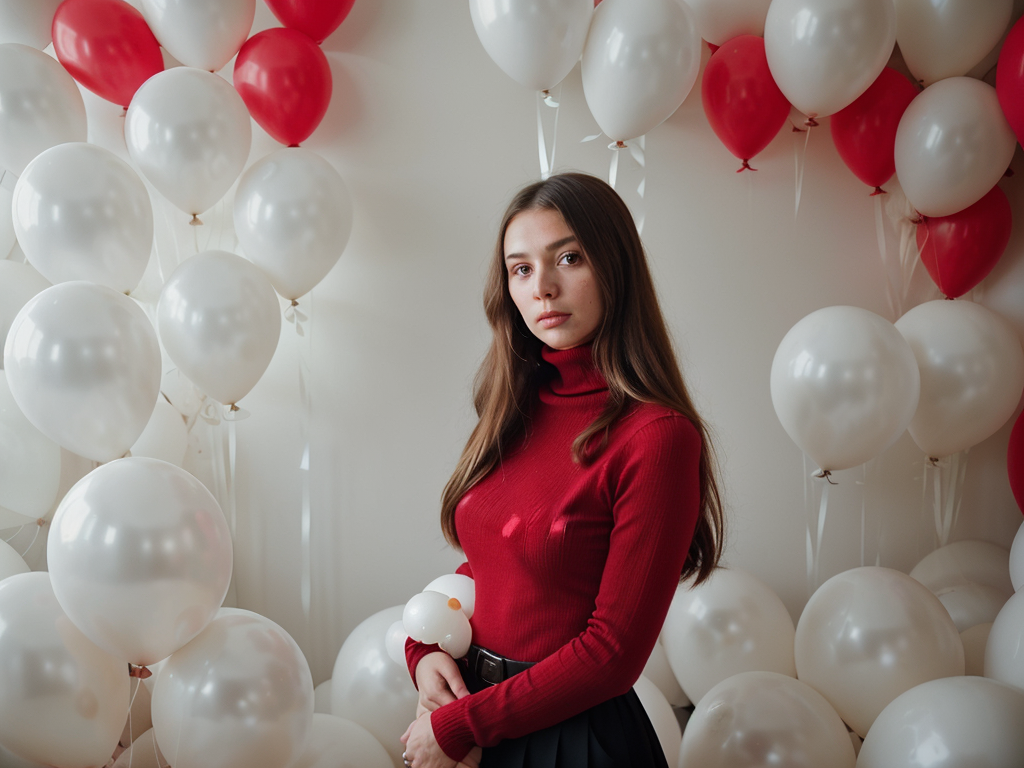

In [ ]:
prompt = "fashion portrait photo of beautiful young woman from the 60s wearing a red turtleneck standing in the middle of a ton of white balloons, taken on a hasselblad medium format camera"
n_prompt = "render, nipples, cartoon, cgi, render, illustration, painting, drawing"

seed=42
img_number = 1
generator = torch.Generator("cpu").manual_seed(seed)
images = pipeline(prompt=[prompt]*img_number,
            negative_prompt=[n_prompt]*img_number,
            generator=generator,
            height=768,
            width=1024,
            num_inference_steps=25,
            ).images
images[0]

In [ ]:
!git clone https://github.com/huggingface/diffusers.git
! pip install omegaconf

Cloning into 'diffusers'...
remote: Enumerating objects: 47002, done.
remote: Counting objects: 100% (4064/4064), done.
remote: Compressing objects: 100% (1336/1336), done.
remote: Total 47002 (delta 2947), reused 3400 (delta 2384), pack-reused 42938
Receiving objects: 100% (47002/47002), 29.57 MiB | 22.63 MiB/s, done.
Resolving deltas: 100% (34752/34752), done.


In [ ]:
!wget -O civitai_midel.ckpt https://civitai.com/api/download/models/201259?type=Model&format=SafeTensor&size=pruned&fp=fp16
!wget https://raw.githubusercontent.com/CompVis/stable-diffusion/main/configs/stable-diffusion/v1-inference.yaml

In [ ]:
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
      --checkpoint_path='/content/civitai_midel.ckpt'\
      --original_config_file='/content/v1-inference.yaml'\
      --dump_path='/content/cache_dir/models/civitai_model'\
      --scheduler_type="ddim" --prediction_type='epsilon'\
      --from_safetensors
